In [1]:
# coding: utf-8
import time
import os
import numpy as np
import keras
from keras import metrics
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Flatten, Reshape, Concatenate
from keras.layers import Conv2D, Conv1D, MaxPooling1D, MaxPooling2D,Activation
from keras.layers import SimpleRNN, GRU,Activation, LSTM

from keras.layers.embeddings import Embedding
from datetime import datetime
from gensim.models import word2vec
from collections import *
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def text_to_index(corpus):
    new_corpus = []
    for doc in corpus:
        new_doc = []
        for word in doc:
            try:
                new_doc.append(word2idx[word])
            except:
                new_doc.append(0)
#         new_doc_arr = np.array(new_doc).reshape(1, max_doc_word_length)
        new_doc_arr = np.array(new_doc)
        new_corpus.append( new_doc_arr)
    return np.array(new_corpus)

In [3]:
# get data
# get texts data
category2idx = {'AllTogether': 0, 'Baseball': 1, 'Boy-Girl': 2, 'C_chat':  3, 'CVS': 4,
                  'GameSale': 5, 'GetMarry': 6, 'Lifeismoney': 7, 'LoL': 8, 'MH': 9, 'MLB': 10, 'Mobilecomm': 11, 
                'movie': 12,'MuscleBeach':  13, 'NBA': 14,  'SENIORHIGH': 15, 'Stock': 16, 
                'Tennis': 17, 'Tos': 18, 'WomenTalk': 19}

train_df_sample = pd.read_pickle('train_reduce.pkl').sample(frac=1, random_state=123)
train_texts = train_df_sample.ari_title
label_list = train_df_sample.price

test_pickle_df = pd.read_pickle('train_reduce.pkl')
test_texts = test_pickle_df["ari_title"].values

train_texts_list = []
for text in train_texts:
    train_texts_list.append(text[0])
    
texts_list = []
for text in train_texts_list:
    texts_list.append(text)
    
for text in test_texts:
    texts_list.append(text)

In [4]:
# get word embedding vector
answer = word2vec.Word2Vec.load("word2vec.model")
word_vectors = answer.wv
wvv = word_vectors.vocab
wvv_keys = wvv.keys()
wvv_keys_list = list(wvv_keys)

vocab_num = len(wvv.items()) + 1

vocab_list = [(word, word_vectors[word]) for word, _ in wvv.items()]

In [5]:
del word_vectors, wvv, train_texts_list, answer

In [6]:
word_vec_len = 50
embedding_matrix = np.zeros((vocab_num , word_vec_len))
word2idx = {}

for i, vocab in enumerate(vocab_list):
    word, vec = vocab
    embedding_matrix[i + 1] = vec
    word2idx[word] = i + 1

In [7]:
embedding_matrix.shape

(46, 50)

In [34]:
embedding_layer = Embedding( input_dim= embedding_matrix.shape[0],output_dim= 50, weights=[embedding_matrix], 
                            input_length = 200,trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(16))    
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 50)           2300      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                4288      
_________________________________________________________________
dense_7 (Dense)              (None, 40)                680       
_________________________________________________________________
dense_8 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 21        
Total params: 8,109
Trainable params: 5,809
Non-trainable params: 2,300
_________________________________________________________________


In [35]:
max_doc_word_length = 200

x_trains_texts = train_df_sample.ari_title.append(test_pickle_df.ari_title)
X_train_texts = text_to_index(x_trains_texts)
X_train = pad_sequences(X_train_texts, maxlen= max_doc_word_length)

print(x_trains_texts.shape)
print(len(label_list))

Y_label_list = np.zeros((6577, 1))
for ids in range(0, 6577):
    Y_label_list[ids]  = label_list[ids] 
print(Y_label_list.shape)

(13154,)
6577
(6577, 1)


In [36]:
epochs_num = 50
history = model.fit(x = X_train[0:6377], y = Y_label_list[0:6377],  
                    batch_size= 100,  epochs = 50, verbose = 1)

Epoch 1/50
6377/6377 [==============================] - 9s 1ms/step - loss: 0.6914 - acc: 0.5335
Epoch 2/50
6377/6377 [==============================] - 8s 1ms/step - loss: 0.6904 - acc: 0.5358
Epoch 3/50
6377/6377 [==============================] - 8s 1ms/step - loss: 0.6902 - acc: 0.5346
Epoch 4/50
6377/6377 [==============================] - 8s 1ms/step - loss: 0.6899 - acc: 0.5360
Epoch 5/50
6377/6377 [==============================] - 8s 1ms/step - loss: 0.6901 - acc: 0.5332
Epoch 6/50
6377/6377 [==============================] - 8s 1ms/step - loss: 0.6894 - acc: 0.5336
Epoch 7/50
6377/6377 [==============================] - 8s 1ms/step - loss: 0.6893 - acc: 0.5332
Epoch 8/50
6377/6377 [==============================] - 7s 1ms/step - loss: 0.6893 - acc: 0.5380
Epoch 9/50
6377/6377 [==============================] - 7s 1ms/step - loss: 0.6888 - acc: 0.5424
Epoch 10/50
6377/6377 [==============================] - 8s 1ms/step - loss: 0.6885 - acc: 0.5319
Epoch 11/50
6377/6377 [======

accuracy 準確度: 


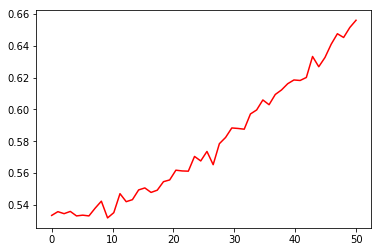

loss 損失函數: 


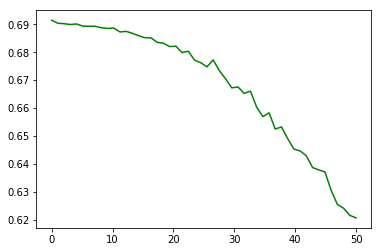

In [37]:
np_loss_history = np.array(history.history['loss'])
np.savetxt("loss_history.txt", np_loss_history, delimiter=",")
loss_history = np.loadtxt("loss_history.txt")

np_acc_history = np.array(history.history['acc'])
np.savetxt("acc_history.txt", np_acc_history, delimiter=",")
acc_history = np.loadtxt("acc_history.txt")

print("accuracy 準確度: ")
fig = plt.figure(1)
ax = plt.axes()
x = np.linspace(0, epochs_num, acc_history.shape[0])
plt.plot(x, acc_history, '-r');  # dotted red
plt.show()


print("loss 損失函數: ")
fig = plt.figure(2)
ax = plt.axes()
x = np.linspace(0, epochs_num, loss_history.shape[0])
plt.plot(x, loss_history, '-g');  # dotted red
plt.show()

In [22]:
# model.save('my_model.h5') 

In [23]:
# evaluate the model
loss_accuracy = model.evaluate(X_train[0:100], Y_label_list[0:100], verbose=1)
print(type(loss_accuracy), loss_accuracy)

test_sequences1 = X_train[6377:6577]

predict_res = model.predict(test_sequences1, batch_size= 1, verbose=0)

# final_res = []
# for pre_res in predict_res:
#     final_res.append(pre_res)
# print(predict_res[0:20])

100/100 [==============================] - 0s 2ms/step
<class 'list'> [0.6601113390922546, 0.6]


In [24]:
# 格式化輸出結果成 1 和 0
# 預測結果小於0.5的保存爲0,表示判斷爲會下跌。否則表示上漲或有限小數位的不變。
final_res = []
for value in predict_res:
    final_res.append(int(round(value[0])))

RIGHT_INDEX= 10
for pv,fv in zip(predict_res[0:RIGHT_INDEX], final_res[0:RIGHT_INDEX]):
    print( repr(pv[0]).ljust(15)[:4] , repr(fv).rjust(3)) 

# print(final_res[:20])

0.64   1
0.38   0
0.64   1
0.47   0
0.52   1
0.68   1
0.54   1
0.66   1
0.63   1
0.59   1


In [25]:
# 和真實的股票指數的變化比較，輸出預測的準確率
x1 = final_res[100:]
x2 = []
for val in Y_label_list[6477:]:
    x2.append(val[0])

acc_i = 0
for v1,v2 in zip(x1, x2):
    compare_res = (v1 == v2)
#     print(compare_res)
    if compare_res:
        acc_i += 1
print("預測準確率爲： ", acc_i / len(x1))

預測準確率爲：  0.62


In [32]:
pre_ress = np.random.randint(2, size=10)
acc_j = 0
# print(pre_ress)
for v1,v2 in zip(pre_ress, x2):
    compare_res = (v1 == v2)
#     print(compare_res)
    if compare_res:
        acc_j += 1
print("random 1 準確率爲： ", acc_j / len(pre_ress))

pre_ress = np.random.randint(2, size=10)
acc_j = 0
# print(pre_ress)
for v1,v2 in zip(pre_ress, x2):
    compare_res = (v1 == v2)
#     print(compare_res)
    if compare_res:
        acc_j += 1
print("random 2 準確率爲： ", acc_j / len(pre_ress))

pre_ress = np.random.randint(2, size=10)
acc_j = 0
# print(pre_ress)
for v1,v2 in zip(pre_ress, x2):
    compare_res = (v1 == v2)
#     print(compare_res)
    if compare_res:
        acc_j += 1
print("random 3 準確率爲： ", acc_j / len(pre_ress))
# print(type(x1), type(x2), x2)

random 1 準確率爲：  0.3
random 2 準確率爲：  0.6
random 3 準確率爲：  0.4


In [27]:
# # result_txt = "result" + str(datetime.now()).split()[1] + ".txt"
# print(len(final_res))
# result_txt = "local_result001" + ".txt"
# ids = 0
# with open(result_txt, 'w') as out:
#     out.write("id,pre_price" + '\n')
#     for value in final_res:
#         out.write(str(ids) + "," + str(int (round(value[0]))) + "," + str(int (round(value[0]))) + '\n')
#         ids += 1